In [329]:
# import off-the-shelf libraries
import os
import imp
import sys
import GPy, scipy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time as timemodule
import copy

print '%s\t\t %s' % ('pandas',pd.__version__)
print '%s\t\t %s' % ('numpy', np.__version__)
print '%s\t\t %s' % ('scipy', scipy.__version__)
print '%s\t\t %s' % ('GPy', GPy.__version__)
print '%s\t\t %s' % ('seaborn', sns.__version__)
print '%s\t %s' % ('matplotlib', mpl.__version__)

# set global parameters
%matplotlib inline
sns.set_style('white')

# import in-house libraries
lib_path = '/Users/firasmidani/Downloads/phenotypic-characterization/'
lib_path_0 = lib_path + 'growth_models/growth.py'
lib_path_1 = lib_path + 'plate_reader_library.py'
lib_path_2 = lib_path + 'growth_fitting_library.py'

foo0 = imp.load_source('growth_models',lib_path_0);
foo1 = imp.load_source('plate_reader_library',lib_path_1);
foo2 = imp.load_source('growth_fitting_library',lib_path_2)

from growth_models import *
from plate_reader_library import *
from growth_fitting_library import *

pandas		 0.22.0
numpy		 1.10.2
scipy		 1.0.0
GPy		 1.9.6
seaborn		 0.8.0
matplotlib	 2.1.1


***WARNING*** ```BiopythonExperimentalWarning```
<br></br></br> 
```Bio.phenotype``` is an experimental submodule which may undergo significant changes prior to its future official release.

## Read Data

In [330]:
data = pd.read_csv('../data/Magellan/PRB954_PM1-1.tsv',sep='\t',header=0,index_col=0);
data.head()

,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
B1,0.282,0.275,0.280,0.281,0.289,0.301,0.312,0.324,0.341,0.355,...,0.487,0.480,0.481,0.485,0.488,0.489,0.479,0.481,0.486,0.478
C1,0.279,0.276,0.278,0.282,0.289,0.297,0.309,0.325,0.339,0.360,...,0.481,0.477,0.478,0.480,0.481,0.482,0.477,0.475,0.479,0.478
D1,0.267,0.266,0.271,0.274,0.282,0.293,0.302,0.321,0.338,0.349,...,0.422,0.424,0.421,0.421,0.422,0.422,0.421,0.418,0.418,0.416
E1,0.279,0.273,0.279,0.278,0.286,0.295,0.309,0.318,0.335,0.364,...,0.487,0.483,0.486,0.492,0.486,0.489,0.487,0.487,0.489,0.491


In [331]:
# format 
print type(data.columns[0])

# convert headers from strings to integers
data.columns = listTimePoints(interval=600,numTimePoints=data.shape[1])

data.index.name = 'Well'
data.T.index.name = 'Time'

print type(data.columns[0])

data.head()

<type 'str'>
<type 'numpy.int64'>


Time,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
B1,0.282,0.275,0.280,0.281,0.289,0.301,0.312,0.324,0.341,0.355,...,0.487,0.480,0.481,0.485,0.488,0.489,0.479,0.481,0.486,0.478
C1,0.279,0.276,0.278,0.282,0.289,0.297,0.309,0.325,0.339,0.360,...,0.481,0.477,0.478,0.480,0.481,0.482,0.477,0.475,0.479,0.478
D1,0.267,0.266,0.271,0.274,0.282,0.293,0.302,0.321,0.338,0.349,...,0.422,0.424,0.421,0.421,0.422,0.422,0.421,0.418,0.418,0.416
E1,0.279,0.273,0.279,0.278,0.286,0.295,0.309,0.318,0.335,0.364,...,0.487,0.483,0.486,0.492,0.486,0.489,0.487,0.487,0.489,0.491


## Read Meta-data

In [332]:
key = populatePlateKey('PRB954_PM1-1');
key.head()

,Isolate,Substrate,Plate
Well,,,
A1,PRB954,Negative Control,PRB954_PM1-1
A2,PRB954,L-Arabanose,PRB954_PM1-1
A3,PRB954,N-Acetyl-D-Glucosamine,PRB954_PM1-1
A4,PRB954,D-Saccharic Acid,PRB954_PM1-1
A5,PRB954,Succinic Acid,PRB954_PM1-1


In [333]:
# remove time points with NaN from data
data = data.iloc[:,np.where(~data.isna().all(0))[0]]
data.head()

Time,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
B1,0.282,0.275,0.280,0.281,0.289,0.301,0.312,0.324,0.341,0.355,...,0.487,0.480,0.481,0.485,0.488,0.489,0.479,0.481,0.486,0.478
C1,0.279,0.276,0.278,0.282,0.289,0.297,0.309,0.325,0.339,0.360,...,0.481,0.477,0.478,0.480,0.481,0.482,0.477,0.475,0.479,0.478
D1,0.267,0.266,0.271,0.274,0.282,0.293,0.302,0.321,0.338,0.349,...,0.422,0.424,0.421,0.421,0.422,0.422,0.421,0.418,0.418,0.416
E1,0.279,0.273,0.279,0.278,0.286,0.295,0.309,0.318,0.335,0.364,...,0.487,0.483,0.486,0.492,0.486,0.489,0.487,0.487,0.489,0.491


In [334]:
# data.T.reset_index()

In [335]:
order_columns = ['Letter','Plate','Row','Column']
order_columns += ['Isolate','Substrate','Max OD','Growth Fold']
order_columns


summary = summarizeGrowthData(data)
summary = summary.join(key)
summary = summary.loc[:,order_columns]

summary.head()

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold
Well,,,,,,,,
A1,A,PRB954_PM1-1,1,1,PRB954,Negative Control,0.214362,1.000000
B1,B,PRB954_PM1-1,2,1,PRB954,D-Serine,0.212137,0.989620
C1,C,PRB954_PM1-1,3,1,PRB954,D-Glucose-6-Phospate,0.216576,1.010329
D1,D,PRB954_PM1-1,4,1,PRB954,L-Asparagine,0.189050,0.881920
E1,E,PRB954_PM1-1,5,1,PRB954,L-Glutamine,0.211803,0.988062


In [336]:
# prepare data for growth dynamics inference
data = data.T
data = data.loc[:,key.index]
data = data.reset_index(drop=False);
data.head()

Well,Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0,0.277,0.282,0.275,0.270,0.269,0.265,0.257,0.248,0.271,...,0.268,0.266,0.263,0.253,0.253,0.246,0.259,0.259,0.258,0.268
1,600,0.275,0.281,0.283,0.269,0.268,0.263,0.254,0.244,0.267,...,0.279,0.279,0.278,0.270,0.263,0.256,0.268,0.262,0.261,0.270
2,1200,0.279,0.286,0.276,0.272,0.273,0.268,0.260,0.248,0.271,...,0.274,0.274,0.277,0.262,0.259,0.256,0.266,0.263,0.261,0.271
3,1800,0.280,0.287,0.288,0.272,0.275,0.269,0.263,0.252,0.275,...,0.271,0.273,0.281,0.260,0.258,0.260,0.266,0.265,0.260,0.271
4,2400,0.289,0.294,0.305,0.279,0.284,0.277,0.268,0.256,0.279,...,0.283,0.286,0.304,0.271,0.269,0.272,0.276,0.272,0.265,0.277


In [337]:
# define plate object and prepare it for analysis
plate = GrowthPlate(data=data,key=summary,control='A1');

In [338]:
plate.key.head()

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold
Well,,,,,,,,
A1,A,PRB954_PM1-1,1,1,PRB954,Negative Control,0.214362,1.000000
B1,B,PRB954_PM1-1,2,1,PRB954,D-Serine,0.212137,0.989620
C1,C,PRB954_PM1-1,3,1,PRB954,D-Glucose-6-Phospate,0.216576,1.010329
D1,D,PRB954_PM1-1,4,1,PRB954,L-Asparagine,0.189050,0.881920
E1,E,PRB954_PM1-1,5,1,PRB954,L-Glutamine,0.211803,0.988062


In [339]:
plate.time.head()

,Time
0,0
1,600
2,1200
3,1800
4,2400


In [340]:
plate.data.head()

Well,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0.277,0.282,0.275,0.270,0.269,0.265,0.257,0.248,0.271,0.265,...,0.268,0.266,0.263,0.253,0.253,0.246,0.259,0.259,0.258,0.268
1,0.275,0.281,0.283,0.269,0.268,0.263,0.254,0.244,0.267,0.260,...,0.279,0.279,0.278,0.270,0.263,0.256,0.268,0.262,0.261,0.270
2,0.279,0.286,0.276,0.272,0.273,0.268,0.260,0.248,0.271,0.265,...,0.274,0.274,0.277,0.262,0.259,0.256,0.266,0.263,0.261,0.271
3,0.280,0.287,0.288,0.272,0.275,0.269,0.263,0.252,0.275,0.270,...,0.271,0.273,0.281,0.260,0.258,0.260,0.266,0.265,0.260,0.271
4,0.289,0.294,0.305,0.279,0.284,0.277,0.268,0.256,0.279,0.273,...,0.283,0.286,0.304,0.271,0.269,0.272,0.276,0.272,0.265,0.277


(0, 1.2)

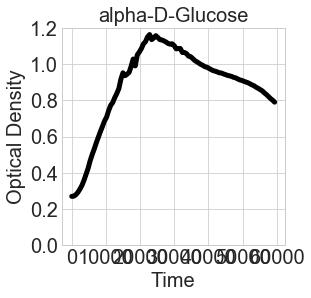

In [341]:
fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot()

ax.set_ylim([0,1.2])

(0, 1.2)

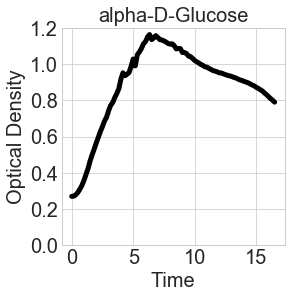

In [342]:
plate.convertTimeUnits()

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot()

ax.set_ylim([0,1.2])

(0, 1.2)

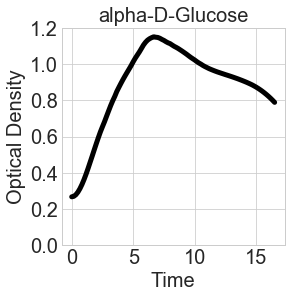

In [343]:
plate.smoothData();

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

ax.set_ylim([0,1.2])

(0, 1.2)

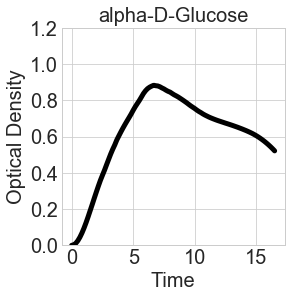

In [344]:
plate.subtractBaseline();

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

ax.set_ylim([0,1.2])

(0, 1.2)

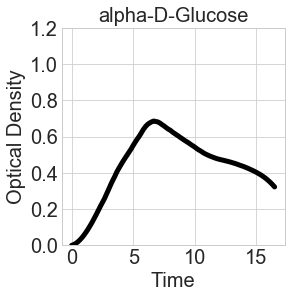

In [345]:
temp = copy.copy(plate)
temp.subtractControl();
fig,ax = temp.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

ax.set_ylim([0,1.2])

In [346]:
?GrowthMetrics.inferDoublingRate()

in
Well
A2    291.782294
Name: classical_r, dtype: float64
out
Doubling Rate is 291.78 minutes


,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,classical_r,classical_K,classical_d,classical_AUC,classical_td
Well,,,,,,,,,,,,,
A2,A,PRB954_PM1-1,1,2,PRB954,L-Arabanose,0.214376,1.000066,0.061902,0.422294,-3.126875,2.911486,291.782294


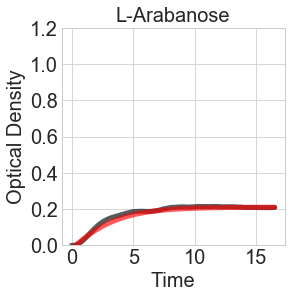

In [347]:
temp = copy.copy(plate)
temp.subtractControl()
temp = temp.extractGrowthData({'Substrate':['alpha-D-Glucose']});

model_fit.Classical(logistic)
model_fit.inferClassicalDynamics()
model_fit.predictClasscial()

fig,ax = model_fit.plot();

ax.set_ylim([0,1.2])

print 'Doubling Rate is %0.2f minutes' % model_fit.key['classical_td']

model_fit.key

Doubling Rate is 123.05 minutes


,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,GP_r,GP_K,GP_AUC,GP_td
Well,,,,,,,,,,,,
C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.146789,0.684227,7.27875,123.045973


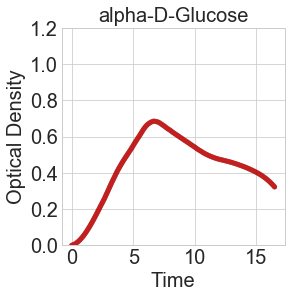

In [348]:
temp = copy.copy(plate)
temp.subtractControl()
temp = temp.extractGrowthData({'Substrate':['alpha-D-Glucose']});

model_fit = GrowthMetrics(temp)
model_fit.GP()
model_fit.inferGPDynamics()
model_fit.predictGP()

fig,ax = model_fit.plot();

ax.set_ylim([0,1.2])

print 'Doubling Rate is %0.2f minutes' % model_fit.key['GP_td']

model_fit.key

In [349]:
growth_summary = pd.DataFrame(index=summary.index,
                              columns=['GP_r','GP_K','GP_AUC','GP_td',
                                       'classical_r','classical_K','classical_AUC','classical_td']);
growth_summary.head()

,GP_r,GP_K,GP_AUC,GP_td,classical_r,classical_K,classical_AUC,classical_td
Well,,,,,,,,
A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [350]:
model_fit.key

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,GP_r,GP_K,GP_AUC,GP_td
Well,,,,,,,,,,,,
C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.146789,0.684227,7.27875,123.045973


In [397]:
counter = 0;
row_count = 1; print '%02d' % row_count,
for well in growth_summary.index:

    if counter<12:
        print '.',
        counter += 1;
    else:
        row_count += 1;
        print '\n%02d .' % row_count,
        counter = 1;

    substrate = plate.key.loc[well,'Substrate']; #print substrate
    growth = plate.extractGrowthData({'Substrate':[substrate]}); # control is not subtracted
    
    
    model_fit = GrowthMetrics(growth)
    model_fit.Classical(gompertz)
    model_fit.inferClassicalDynamics()
    #model_fit.predictClasscial()

    to_header = ['classical_r','classical_K','classical_AUC','classical_td'];
    to_index = model_fit.key.index[0]
    growth_summary.loc[to_index,to_header] = model_fit.key.loc[to_index,to_header].values

    model_fit = GrowthMetrics(growth)
    model_fit.GP()
    model_fit.inferGPDynamics()
    #model_fit.predictGP()

    to_header = ['GP_r','GP_K','GP_AUC','GP_td'];
    to_index = model_fit.key.index[0]
    growth_summary.loc[to_index,to_header] = model_fit.key.loc[to_index,to_header].values


01 . . . . . . . . . . . . 
02 . . . . . . . . . . . . 
03 . . . . . . . . . . . . 
04 . . . . . . . . . . . . 
05 . . . . . . . . . . . . 
06 . . . . . . . . . . . . 
07 . . . . . . . . . . . . 
08 . . . . . . . . . . . .


In [398]:
summary_df = summary.join(growth_summary).sort_values(['GP_td'],ascending=True)
summary_df.head(10)

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,GP_r,GP_K,GP_AUC,GP_td,classical_r,classical_K,classical_AUC,classical_td
Well,,,,,,,,,,,,,,,,
A3,A,PRB954_PM1-1,1,3,PRB954,N-Acetyl-D-Glucosamine,0.758015,3.536141,0.239662,0.749975,7.71088,75.3635,-0.129272,0.334724,7.69822,-139.72
C7,C,PRB954_PM1-1,3,7,PRB954,D-Fructose,0.825154,3.849344,0.2111,0.826966,9.22905,85.5606,0.28061,0.609189,9.2014,64.3661
C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.205,0.881691,10.2644,88.1064,0.269402,0.691891,10.221,67.0441
G4,G,PRB954_PM1-1,7,4,PRB954,L-Threonine,0.440850,2.056564,0.153953,0.428893,5.76831,117.32,0.149652,0.422534,5.73849,120.692
B11,B,PRB954_PM1-1,2,11,PRB954,D-Mannitol,0.792709,3.697988,0.15031,0.793576,8.70129,120.164,0.165322,0.628354,8.661,109.252
G3,G,PRB954_PM1-1,7,3,PRB954,L-Serine,0.440657,2.055666,0.125784,0.4353,5.55285,143.593,0.138438,0.388693,5.5239,130.468
A11,A,PRB954_PM1-1,1,11,PRB954,D-Mannose,0.655933,3.059927,0.116306,0.658264,7.50059,155.295,75.5504,1161.84,7.44579,0.23907
D7,D,PRB954_PM1-1,4,7,PRB954,alpha-Keto-Butyric Acid,0.345211,1.610409,0.114142,0.342876,4.6126,158.24,0.0906037,0.531059,4.58494,199.35
H12,H,PRB954_PM1-1,8,12,PRB954,2-Aminoethanol,0.387359,1.807031,0.108628,0.39047,5.26494,166.273,0.132679,0.364329,5.23577,136.131


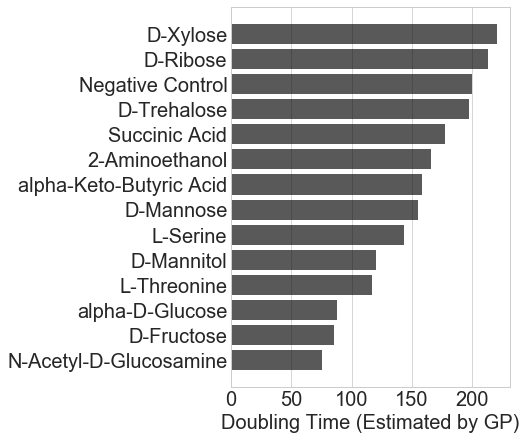

In [400]:
fig,ax = plt.subplots(figsize=[5,7]);

# grab all growth curves with at least 1.5 fold change (relative to negative control)
subset = list(summary_df[summary_df['Growth Fold']>1.5].Substrate.values)+list(['Negative Control']);

labels = summary_df[summary_df.isin({'Substrate':subset}).any(1)].Substrate
data = summary_df[summary_df.isin({'Substrate':subset}).any(1)].GP_td;

ax.barh(y=range(len(labels)),width=data,height=0.8,color=(0,0,0,0.65));

[ii.set(fontsize=20) for ii in ax.get_xticklabels()+ax.get_yticklabels()];

ax.set_xlabel('Doubling Time (Estimated by GP)',fontsize=20);
plt.setp(ax,yticks=range(len(labels)),yticklabels=labels);
ax.yaxis.grid(False)

** What happens if you subtract the negative control from all growth curves?**

In [402]:
temp = copy.copy(plate)
temp.subtractControl()

In [403]:
counter = 0;
row_count = 1; print '%02d' % row_count,
for well in growth_summary.index:

    if counter<12:
        print '.',
        counter += 1;
    else:
        row_count += 1;
        print '\n%02d .' % row_count,
        counter = 1;

    substrate = plate.key.loc[well,'Substrate']; #print substrate
    growth = temp.extractGrowthData({'Substrate':[substrate]}); # control is not subtracted
    
    
    model_fit = GrowthMetrics(growth)
    model_fit.Classical(gompertz)
    model_fit.inferClassicalDynamics()
    #model_fit.predictClasscial()

    to_header = ['classical_r','classical_K','classical_AUC','classical_td'];
    to_index = model_fit.key.index[0]
    growth_summary.loc[to_index,to_header] = model_fit.key.loc[to_index,to_header].values

    model_fit = GrowthMetrics(growth)
    model_fit.GP()
    model_fit.inferGPDynamics()
    #model_fit.predictGP()

    to_header = ['GP_r','GP_K','GP_AUC','GP_td'];
    to_index = model_fit.key.index[0]
    growth_summary.loc[to_index,to_header] = model_fit.key.loc[to_index,to_header].values


01 .

 /Users/firasmidani/Downloads/phenotypic-characterization/growth_fitting_library.py:46: RuntimeWarning:invalid value encountered in double_scalars
 /Users/firasmidani/Downloads/phenotypic-characterization/growth_fitting_library.py:46: RuntimeWarning:divide by zero encountered in double_scalars
 /Users/firasmidani/Downloads/phenotypic-characterization/growth_fitting_library.py:46: RuntimeWarning:invalid value encountered in multiply


 .

 /Users/firasmidani/Downloads/phenotypic-characterization/growth_fitting_library.py:46: RuntimeWarning:overflow encountered in exp


 . . . . . . . . . . 
02 . . . . . . . . . . . . 
03 . . . . . . . . . . . . 
04 . . . . . . . . . . . . 
05 . . . . . . . . . . . . 
06 . . . . . . . . . . . . 
07 . . . . . . . . . . . . 
08 . . . . . . . . . . . .


In [404]:
summary_temp_df = summary.join(growth_summary).sort_values(['GP_td'],ascending=True)
summary_temp_df.head(10)

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,GP_r,GP_K,GP_AUC,GP_td,classical_r,classical_K,classical_AUC,classical_td
Well,,,,,,,,,,,,,,,,
A3,A,PRB954_PM1-1,1,3,PRB954,N-Acetyl-D-Glucosamine,0.758015,3.536141,0.153688,0.554515,4.72524,117.522,0.172857,-0.357424,4.72918,104.49
C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.146789,0.684227,7.27875,123.046,0.215741,0.479225,7.25191,83.72
C7,C,PRB954_PM1-1,3,7,PRB954,D-Fructose,0.825154,3.849344,0.134278,0.628944,6.2434,134.51,-5.05791,0.125663,6.23236,-3.571
B11,B,PRB954_PM1-1,2,11,PRB954,D-Mannitol,0.792709,3.697988,0.0975223,0.57947,5.71565,185.207,0.129104,0.409847,5.69196,139.902
H12,H,PRB954_PM1-1,8,12,PRB954,2-Aminoethanol,0.387359,1.807031,0.0890206,0.1909,2.2793,202.895,0.102848,0.164981,2.26672,175.616
G4,G,PRB954_PM1-1,7,4,PRB954,L-Threonine,0.440850,2.056564,0.0857792,0.22142,2.78266,210.561,0.0865318,0.21067,2.76945,208.73
A11,A,PRB954_PM1-1,1,11,PRB954,D-Mannose,0.655933,3.059927,0.0751329,0.460198,4.51495,240.398,4.35247,137.828,4.47674,4.14978
H5,H,PRB954_PM1-1,8,5,PRB954,D-Psicose,0.243431,1.135607,0.0692623,0.0481916,0.532818,260.774,0.0850449,0.0332113,0.531,212.38
G3,G,PRB954_PM1-1,7,3,PRB954,L-Serine,0.440657,2.055666,0.0657536,0.237711,2.56721,274.689,0.0850767,0.175967,2.55485,212.3


In [407]:
summary_temp_df.tail(1)

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,GP_r,GP_K,GP_AUC,GP_td,classical_r,classical_K,classical_AUC,classical_td
Well,,,,,,,,,,,,,,,,
A1,A,PRB954_PM1-1,1,1,PRB954,Negative Control,0.214362,1.0,0,0,0,inf,0,0,0,inf


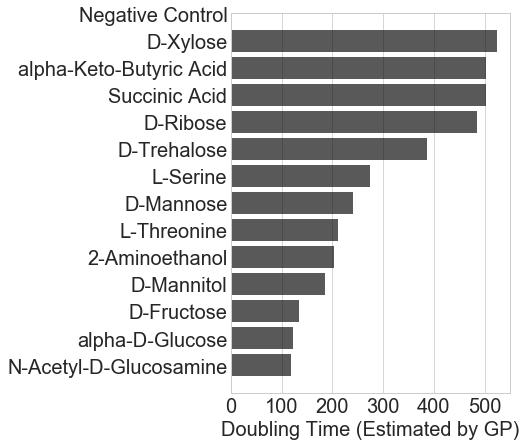

In [406]:
fig,ax = plt.subplots(figsize=[5,7]);

# grab all growth curves with at least 1.5 fold change (relative to negative control)
subset = list(summary_temp_df[summary_temp_df['Growth Fold']>1.5].Substrate.values)+list(['Negative Control']);

labels = summary_temp_df[summary_temp_df.isin({'Substrate':subset}).any(1)].Substrate
data = summary_temp_df[summary_temp_df.isin({'Substrate':subset}).any(1)].GP_td;

ax.barh(y=range(len(labels)),width=data,height=0.8,color=(0,0,0,0.65));

[ii.set(fontsize=20) for ii in ax.get_xticklabels()+ax.get_yticklabels()];

ax.set_xlabel('Doubling Time (Estimated by GP)',fontsize=20);
plt.setp(ax,yticks=range(len(labels)),yticklabels=labels);
ax.yaxis.grid(False)